In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer,BertForSequenceClassification, Trainer,TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

In [ ]:
#data loading
df = pd.read_csv("/content/train.csv", encoding='ISO-8859-1')

#keeping only necessary columns
df= df[['sentiment','text']].dropna()

#mapping sentiment labels to numbers
label_map= {'positive': 2,'negative': 0,'neutral': 1}
df['label']=df['sentiment'].map(label_map)

df=df[['text', 'label']]

#for quicker training/testing
df=df.sample(10000, random_state=42)


In [ ]:
#tokenizing
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

dataset=Dataset.from_pandas(df)
tokenized_dataset=dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
#data splitting (80 training, 20 test)
train_test=tokenized_dataset.train_test_split(test_size=0.2)
train_dataset= train_test["train"]
eval_dataset= train_test["test"]

In [ ]:
#loading the pre-trained model: BERT-large
model= BertForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=3)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments,Trainer

In [ ]:
#defining arquements
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
)

In [ ]:
#training
trainer = Trainer(#AdamW optimizer is used internally
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

trainer.train()


<ipython-input-11-2baf9b12ce11>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: danytbdallh (danytbdallh-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,1.044800
200,0.804900
300,0.750600
400,0.669100
500,0.580600
600,0.628600
700,0.637000
800,0.610300
900,0.557800
1000,0.559900


In [ ]:
#testing
trainer.evaluate()#CrossEntropyLoss is used here implicitly

{'eval_loss': 0.8749158978462219}

In [ ]:
import numpy as np

#making prediction
pred=trainer.predict(eval_dataset)
pred_labels=np.argmax(pred.predictions, axis=1)
true_labels=eval_dataset['label']

Accuracy: 0.7935
F1-Score: 0.7937197408598704


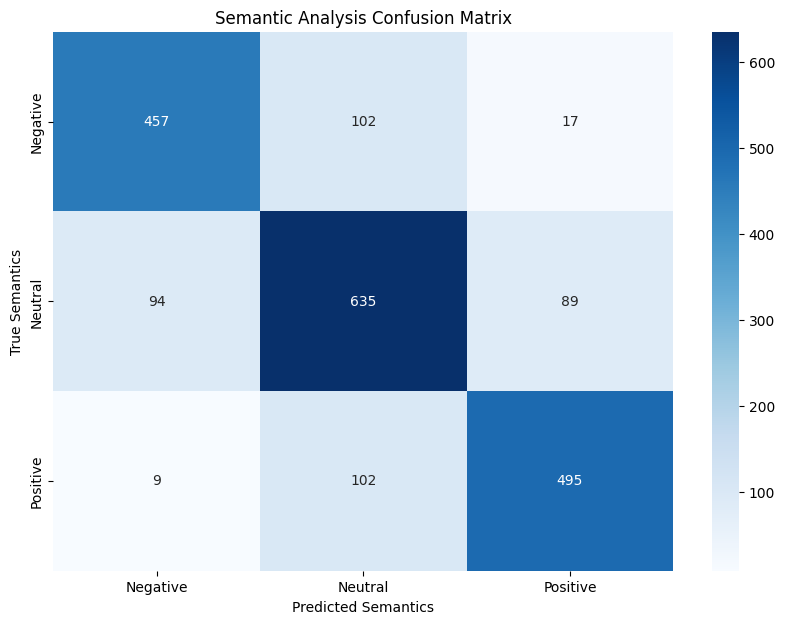

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#evaluating model's prediction
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, pred_labels)

print("Accuracy:", accuracy)
print("F1-Score:", f1)

#display confusion matrix
labels=['Negative','Neutral','Positive']

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap='Blues',
            xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted Semantics')
plt.ylabel('True Semantics')
plt.title('Semantic Analysis Confusion Matrix')
plt.show()

In [ ]:
#saving model
model.save_pretrained("models/")
tokenizer.save_pretrained("models/")
torch.save(model.state_dict(), "models/bert_large_finetuned.pt")

In [ ]:
import shutil
shutil.make_archive('bert_model', 'zip', 'models')

'/content/bert_model.zip'

In [ ]:
from google.colab import files
files.download('bert_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp bert_model.zip /content/drive/MyDrive/
